In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import phik
from phik.report import plot_correlation_matrix
from phik import report

#### Data Ingestion

DATA DESCRIPTION:<br>
Input features:<br>
Objective: factual information;<br>
Examination: results of medical examination;<br>
Subjective: information given by the patient.<br>

Features:<br>
Age | Objective Feature | age | int (days)<br>
Height | Objective Feature | height | int (cm) |<br>
Weight | Objective Feature | weight | float (kg) |<br>
Gender | Objective Feature | gender | categorical code | 1 - women, 2 - men |<br>
Systolic blood pressure | Examination Feature | ap_hi | int |<br>
Diastolic blood pressure | Examination Feature | ap_lo | int |<br>
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |<br>
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |<br>
Smoking | Subjective Feature | smoke | binary | 1-Yes, 0-No<br>
Alcohol intake | Subjective Feature | alco | binary | 1-Yes, 0-No<br>
Physical activity | Subjective Feature | active | binary | 1-Yes, 0-No<br>
Presence or absence of cardiovascular disease | Target Variable | cardio | binary | 1-Yes, 0-No” <br>


In [102]:
df = pd.read_csv('cardio_train 3.csv',sep=';') 

#### Data Pre-Processing

In [103]:
#display first 5 rows
df.head(20)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


#### Removing duplicates to avoid skewed results during data analysis that can lead to inaccurate recommendations

In [104]:
df['id'].value_counts() #no duplicates found hence keep all rows

0        1
66623    1
66631    1
66630    1
66628    1
        ..
33338    1
33339    1
33340    1
33341    1
99999    1
Name: id, Length: 70000, dtype: int64

Converting age from number of days to year

In [105]:
df['age'] = (df['age'] / 365.25).astype(int)

df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


#### Data Observation

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


#### Data imputation to preserve statistical power, avoid bias as much as possible.

In [107]:
def produce_missing_report(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({
                                     'percent_missing': percent_missing})
    return missing_value_df

produce_missing_report(df)

,percent_missing
id,0.0
age,0.0
gender,0.0
height,0.0
weight,0.0
ap_hi,0.0
ap_lo,0.0
cholesterol,0.0
gluc,0.0
smoke,0.0


#### Data Standardization

In [108]:
def standardize_col(col):
    scaler = StandardScaler()
    std_col = scaler.fit_transform(col.values.reshape(-1, 1))
    return std_col

standardize_col(df['age'])
standardize_col(df['height'])
standardize_col(df['weight'])
standardize_col(df['ap_hi'])
standardize_col(df['ap_lo'])
df.head(5)
# df.iloc[168]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


#### Outlier Detection analysis on the age, height, weight, ap_hi, and ap_lo columns, since they are continuous numerical variables that may have outliers.

Performing outlier detection on the age column

In [109]:
df['age'].describe()

count    70000.000000
mean        52.803257
std          6.762462
min         29.000000
25%         48.000000
50%         53.000000
75%         58.000000
max         64.000000
Name: age, dtype: float64

In [110]:
Q1 = df['age'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['age'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  48.0
Q3  58.0
IQR 10.0


In [111]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  73.0
lower  33.0


In [112]:
df_without_outliers = df[(df['age'] < upper_bound) & (df['age'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x140cd8df0>,
 'caps': [<matplotlib.lines.Line2D at 0x140cd9330>,
 'boxes': [<matplotlib.lines.Line2D at 0x140cd8b50>],
 'medians': [<matplotlib.lines.Line2D at 0x140cd9870>],
 'fliers': [<matplotlib.lines.Line2D at 0x140cd9b10>],
 'means': []}

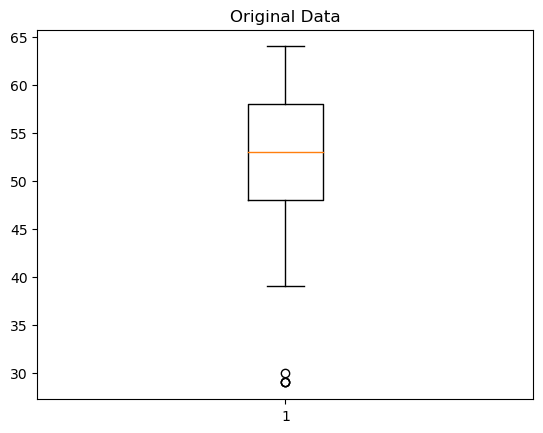

In [113]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Data')
ax1.boxplot(df['age'])

{'whiskers': [<matplotlib.lines.Line2D at 0x140d51090>,
 'caps': [<matplotlib.lines.Line2D at 0x140d515d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x140d50df0>],
 'medians': [<matplotlib.lines.Line2D at 0x140d51b10>],
 'fliers': [<matplotlib.lines.Line2D at 0x140d51db0>],
 'means': []}

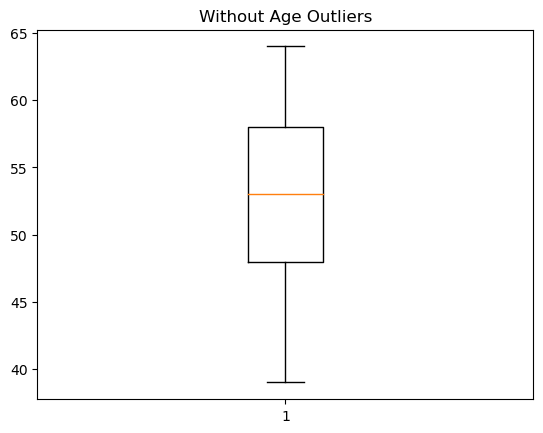

In [114]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Age Outliers')
ax1.boxplot(df_without_outliers['age'])

In [115]:
df_without_outliers = df[(df['age'] > lower_bound) & (df['age'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69991,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69992,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69993,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69994,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the height column

In [116]:
df['height'].describe() # uncertain of if this is needed, people have varied height doesnt mean it contributes to CVD. however the column continuous. do correlation matrix to see the relevance

count    69996.000000
mean       164.359063
std          8.210122
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64

In [117]:
Q1 = df['height'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['height'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  159.0
Q3  170.0
IQR 11.0


In [118]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  186.5
lower  142.5


In [119]:
df_without_outliers = df[(df['height'] < upper_bound) & (df['height'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69991,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69992,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69993,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69994,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x140da3dc0>,
 'caps': [<matplotlib.lines.Line2D at 0x140dc8340>,
 'boxes': [<matplotlib.lines.Line2D at 0x140da3b20>],
 'medians': [<matplotlib.lines.Line2D at 0x140dc8880>],
 'fliers': [<matplotlib.lines.Line2D at 0x140dc8b20>],
 'means': []}

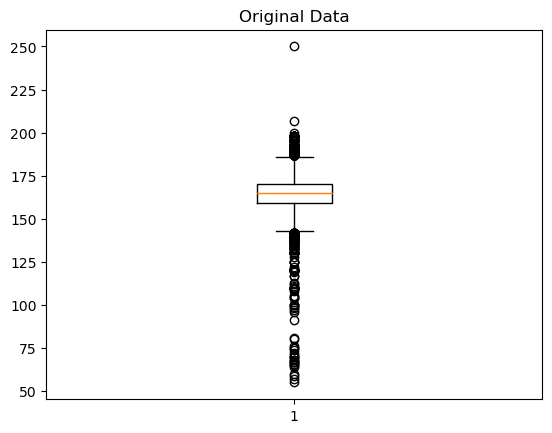

In [120]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Data')
ax1.boxplot(df['height'])

{'whiskers': [<matplotlib.lines.Line2D at 0x140e38cd0>,
 'caps': [<matplotlib.lines.Line2D at 0x140e39210>,
 'boxes': [<matplotlib.lines.Line2D at 0x140e38a30>],
 'medians': [<matplotlib.lines.Line2D at 0x140e39630>],
 'fliers': [<matplotlib.lines.Line2D at 0x140e398d0>],
 'means': []}

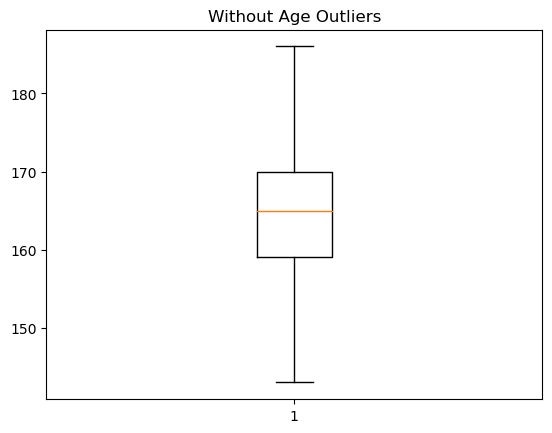

In [121]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Age Outliers')
ax1.boxplot(df_without_outliers['height'])

In [122]:
df_without_outliers = df[(df['height'] > lower_bound) & (df['height'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69472,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69473,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69474,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69475,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the weight column

In [123]:
df['weight'].describe()

count    69477.000000
mean        74.152953
std         14.287850
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64

In [124]:
Q1 = df['weight'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['weight'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  65.0
Q3  82.0
IQR 17.0


In [125]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  107.5
lower  39.5


In [126]:
df_without_outliers = df[(df['weight'] < upper_bound) & (df['weight'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69471,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
69472,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69474,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69475,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x140e82980>,
 'caps': [<matplotlib.lines.Line2D at 0x140e82da0>,
 'boxes': [<matplotlib.lines.Line2D at 0x140e803a0>],
 'medians': [<matplotlib.lines.Line2D at 0x140e832e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x140e83580>],
 'means': []}

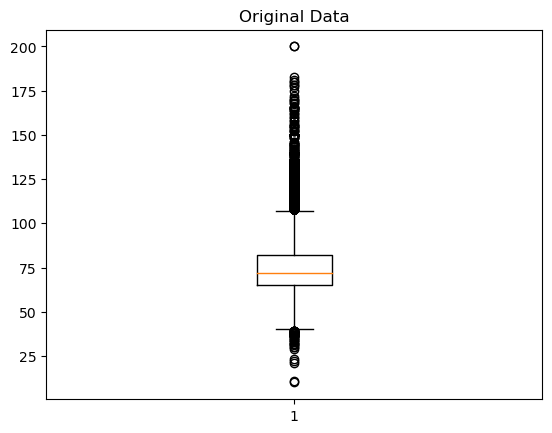

In [127]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Data')
ax1.boxplot(df['weight'])

{'whiskers': [<matplotlib.lines.Line2D at 0x140efae00>,
 'caps': [<matplotlib.lines.Line2D at 0x140efb340>,
 'boxes': [<matplotlib.lines.Line2D at 0x140ef8d00>],
 'medians': [<matplotlib.lines.Line2D at 0x140efb760>],
 'fliers': [<matplotlib.lines.Line2D at 0x140efba00>],
 'means': []}

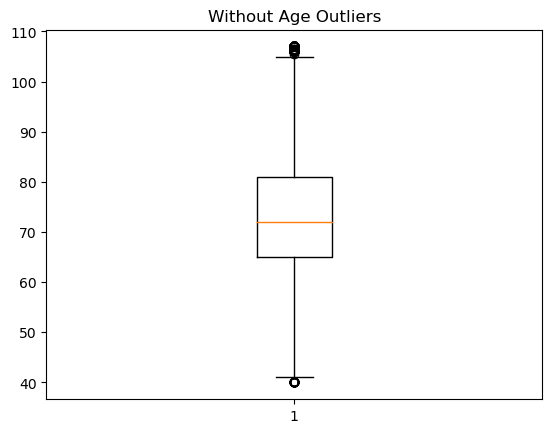

In [128]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Age Outliers')
ax1.boxplot(df_without_outliers['weight'])

In [129]:
df_without_outliers = df[(df['weight'] > lower_bound) & (df['weight'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67714,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
67715,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
67716,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
67717,99998,61,1,163,72.0,135,80,1,2,0,0,0,1
